In [1]:

import os
import re
import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import xml.etree.ElementTree as ET
from io import StringIO
from datetime import datetime
from dataclasses import dataclass, field

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from functions.display import display

In [2]:
year = '2023-01-01'
params = {
    'page[size]': '5000',
    'page[number]': '1',
    'filter': f'record_date:gte:{year}',
    'format': 'csv'
}
endpoint = '/v1/accounting/dts/deposits_withdrawals_operating_cash'
base_url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service'
url = base_url + endpoint

In [3]:
@dataclass
class Data:
    url: str
    rows: int = 0
    df: pd.DataFrame = None
    last_accessed: datetime = None
    params: dict = field(default_factory=dict)
    
    def __post_init__(self):
        """
        Initialize the sub_menu dictionary.
        To add more menu options, create the function and add it to the sub_menu dictionary.
        Follow the format shown below. Use nested dictionaries to create sub menus.
        """
        self.sub_menu = {
            "Back": 'back',
            "Search": self.search,
            "Parameters": {
                "Back": 'back',
                "List parameters": self.list_parameters,
                "Edit parameters": self.edit_parameters
            },
            "Data": {
                "Back": 'back',
                "View all": self.view_data,
                "View size": self.view_data_size
            }
        }
    
    def json_to_df(self, response) -> pd.DataFrame:
        "Takes JSON as input and adds it to the dataframe"
        
        json_data = response.json().get('data', [])
        df = pd.DataFrame(json_data)
        self.df = pd.concat([self.df, df], ignore_index=True)
    
    def csv_to_df(self, response) -> pd.DataFrame:
        "Takes CSV as input and adds it to the dataframe"
        
        df = pd.read_csv(StringIO(response.content.decode('utf-8')))
        self.df = pd.concat([self.df, df], ignore_index=True)
    
    def xml_to_df(self, response) -> pd.DataFrame:
        "Takes XML as input and adds it to the dataframe"
        
        root = ET.fromstring(response.content)
        data = [{subchild.tag: subchild.text for subchild in child} for child in root]
        df = pd.DataFrame(data)
        self.df = pd.concat([self.df, df], ignore_index=True)
    
    def search(self) -> pd.DataFrame:
        """
        Fetches all data from the API by handling pagination (The amount of data returned at one time).
        """
        while True:
            # Make the request to the API
            params = {k: v for k, v in self.params.items() if v is not None}
            response = requests.get(self.url, params=params)

            # Check if the request was successful
            if response.status_code != 200:
                break
            
            # Finds out if the content type is JSON, CSV, or XML
            content_type = response.headers.get('Content-Type').split(';')[0].strip().split('/')[1]
            
            match content_type:
                case 'json':
                    self.json_to_df(response)
                case 'csv':
                    self.csv_to_df(response)
                case 'xml':
                    self.xml_to_df(response)
                case _:
                    print(f'Unknown content type: {content_type}')
            
            print(f'Total entries so far({content_type}): {len(self.df)}')

            # Increment the page number for the next request
            self.params['page[number]'] = str(int(self.params['page[number]']) + 1)

        self.rows = len(self.df)
        self.last_accessed = datetime.now()

        return
    
    def list_parameters(self):
        for item in self.params:
            print(item)
    
    def edit_parameters(self, params):
        choice = display(params)
        self.params = params
    
    def view_data_size(self):
        print(f'Total entries in dataset: {self.rows}')
    
    def view_data(self):
        print(self.df.describe())

In [4]:
data = Data(url=url, params=params)
display(data.sub_menu)


Choose an option:
1. Back      
2. Search    
3. Parameters
4. Data      
Total entries so far(csv): 5000
Total entries so far(csv): 10000
Total entries so far(csv): 15000
Total entries so far(csv): 20000
Total entries so far(csv): 25000
Total entries so far(csv): 30000
Total entries so far(csv): 35000
Total entries so far(csv): 40000
Total entries so far(csv): 45000
Total entries so far(csv): 50000
Total entries so far(csv): 55000
Total entries so far(csv): 60000
Total entries so far(csv): 65000
Total entries so far(csv): 70000
Total entries so far(csv): 75000
Total entries so far(csv): 80000
Total entries so far(csv): 85000
Total entries so far(csv): 87205

Choose an option:
1. Back      
2. Search    
3. Parameters
4. Data      


In [ ]:
data_list = list(data.df['transaction_catg'].dropna().unique())
departments = {}
for i in data_list:
    print(i)
    try:
        if ' - ' in i:  # Only split if ' - ' is present
            code, name = i.split(' - ', maxsplit=1)
            
            # Check if code is actually in parenthesis
            match = re.search(r'\((.*?)\)', code)
            cleaned_text = re.sub(r'\s*\(.*\)', '', code)

            if match:
                code = match.group(1)
                name = cleaned_text
                
            if code in departments:
                departments[code].append(name)
            else:
                departments[code] = [name]
    except ValueError:
        print(f'Value Error: {i}')

Cash FTD's Received (Table IV)
Dept of Agriculture (USDA) - misc
USDA - Commodity Credit Corporation
USDA - Federal Crop Insurance Corp Fund
USDA - Loan Repayments
Dept of Commerce (DOC)
Dept of Education (ED)
Dept of Energy (DOE)
Dept of Health & Human Serv (HHS) - Misc
HHS - Marketplace Receipts
HHS - Medicare Premiums
Dept of Homeland Security (DHS) - misc
DHS - Customs and Certain Excise Taxes
DHS - Fed Emergency Mgmt Agency (FEMA)
DHS - Seized Assets
DHS - Transportation Security Admn (TSA)
Dept of Housing & Urban Dev (HUD) - misc
HUD - Federal Housing Admin (FHA)
Dept of Interior (DOI) - misc
DOI - Fish and Wildlife and Parks
DOI - Gas and Oil Lease Sales Proceeds
DOI - Land and Minerals Management
DOI - Water and Science
Dept of Justice (DOJ)
Dept of Labor (DOL) - misc
DOL - Pension Benefit Guaranty Corp.
Dept of State (DOS)
Dept of Transportation (DOT)
Dept of Treasury (TREAS) - misc
TREAS - Bureau of Engraving and Printing
TREAS - Comptroller of the Currency
TREAS - Federal Fi

In [6]:
# for k, v in departments.items():
#     for i in v:
#         print(f'{k} - {i}')

In [7]:
data.df.columns

Index(['record_date', 'account_type', 'transaction_type', 'transaction_catg',
       'transaction_catg_desc', 'transaction_today_amt', 'transaction_mtd_amt',
       'transaction_fytd_amt', 'table_nbr', 'table_nm', 'src_line_nbr',
       'record_fiscal_year', 'record_fiscal_quarter', 'record_calendar_year',
       'record_calendar_quarter', 'record_calendar_month',
       'record_calendar_day'],
      dtype='object')

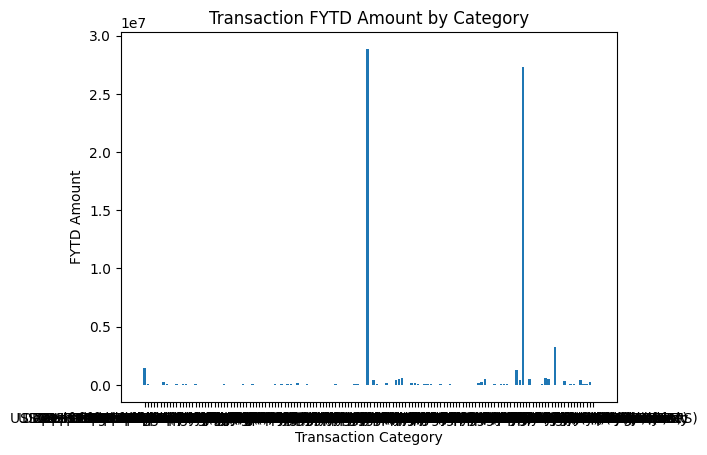

In [27]:
df = data.df.dropna(subset=['transaction_catg'])
deposits = df['transaction_catg'] == 'Sub-Total Deposits'
withdrawals = df['transaction_catg'] == 'Sub-Total Withdrawals'
df = df[~deposits & ~withdrawals]

# # Create a bar chart
# fig = px.bar(
#     df, 
#     x='transaction_catg', 
#     y='transaction_fytd_amt', 
#     title='Transaction FYTD Amount by Category',
#     labels={'transaction_catg': 'Transaction Category', 'transaction_fytd_amt': 'FYTD Amount'},
#     color='transaction_catg'  # Optional: Add color to distinguish categories
# )

# # Show the plot
# fig.show()

plt.bar(df['transaction_catg'], df['transaction_fytd_amt'], label='Line 1')
plt.xlabel('Transaction Category')
plt.ylabel('FYTD Amount')
plt.title('Transaction FYTD Amount by Category')
plt.show()

In [ ]:
def map_to_parent(category):
    for parent in departments:
        # Safely handle cases where `parent` has only one word
        parts = parent.split(' ', 1)  # Split only once
        if len(parts) > 1 and re.search(parts[1], category):  # Match the second part if it exists
            return parent
    return 'Unclassified'

# Apply the mapping
df['parent_branch'] = df['transaction_catg'].apply(map_to_parent)

# Group by parent branch and sum transaction amounts
grouped_data = df.groupby('parent_branch')['transaction_fytd_amt'].sum().reset_index()

print(grouped_data)


          parent_branch  transaction_fytd_amt
0  Independent Agencies               2849418
1       Judicial Branch               2022696
2          Unclassified           14778754768


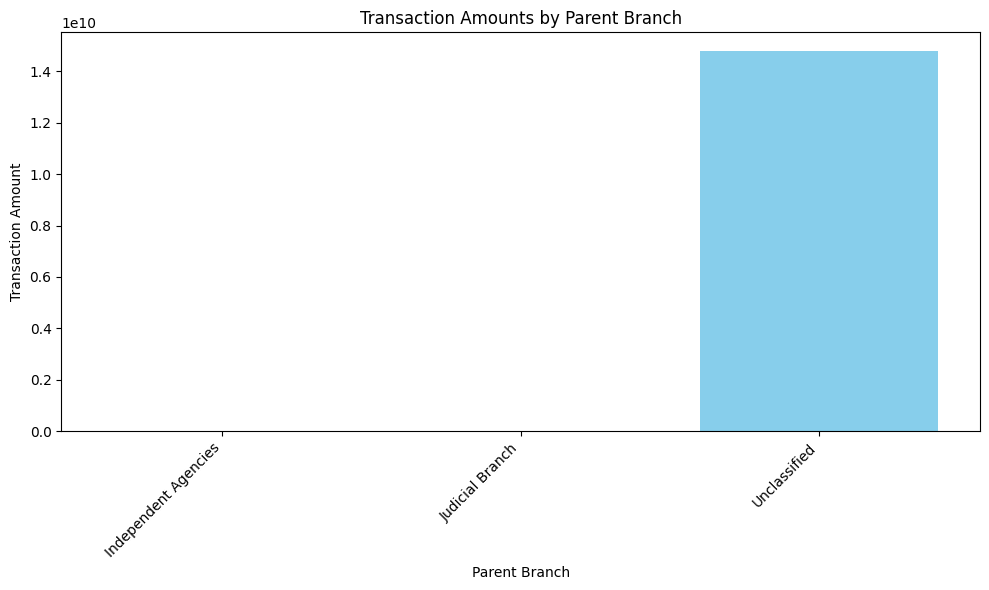

In [51]:
# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['parent_branch'], grouped_data['transaction_fytd_amt'], color='skyblue')
plt.xlabel('Parent Branch')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amounts by Parent Branch')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.tight_layout()
plt.show()
